# Problem Set 1 (PS1): Overlapping K-means example
The lecture introduced the [K-means clustering technique](https://en.wikipedia.org/wiki/K-means_clustering) as part of our unsupervised learning discussion. The [K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) is straightforward and, in some ways, intuitive, but it has several limitations, such as the necessity to specify the number of clusters in advance. Additionally, there are more significant concerns, such as the inability to cluster overlapping datasets (or non-convex datasets). Let's explore the overlapping data issue!

* __Problem__: There was an example cited [in the MAT 180 Big Data course at UC Davis](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180coursematerial.html) that was not explored in detail that we'll use (with some modifications) as the basis for our study. Consider two circular data clouds, each of radius 1, and their centers are a distance $d$ apart. As long as $d > 2.08$, [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) yields the correct answer. But if $d\leq{2.08}$, [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) may fail. Moreover, this is the failure of [K-means](https://en.wikipedia.org/wiki/K-means_clustering) and not of Lloyd's algorithm, i.e., Lloyd's algorithm will converge, but to an incorrect answer.

To explore this problem, work through each notebook section, fill in any missing codes, and answer any discussion questions. The testing section of the notebook displays a list of tests to help you check the correctness (and completeness) of the problem set.

## Setup, Prerequisites and Data
In this section, we set up the computational environment by including the `Include.jl` file and then load any needed resources, e.g., a sample dataset, to cluster, and we end by setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [1284]:
include("Include.jl"); # nothing to do here, move along ...

Next, let's set some constants. See the comment next to the constant for a description of what it is, permissible values, etc.

In [1286]:
number_label_one = 500; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 500; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a faux label; see below.
c̄₁ = (1.0, 1.0); # center for cluster 1: fixed
c̄₂ = (1.1, 1.0); # center for cluster 2: variable, we'll change this in our study
maxiter = 10000; # maximum iterations of our K-means implementation
K = 2; # number of clusters. We'll change this in our study (K > 1)
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Now, check if the distances between the centers are greater than (or less than) the critical threshold. We'll return distance, and a label for this case we are exploring.

In [1288]:
distance, case_label = let
    
    d = Euclidean(); # distance measure from the Distances.jl package
    distance = d(c̄₁,c̄₂); # compute the distance

    # check the case: {distinct | overlap}
    case_label = "distinct"
    if (distance ≤ 2.08)
        case_label = "overlapping"
    end

    # return the data to the calling scope
    distance, case_label    
end;

In [1289]:
println("Distance: $(distance) with case_label: $(case_label)")

Distance: 0.10000000000000009 with case_label: overlapping


Finally, let's set up the color dictionary to visualize the clustering results. The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index. We have initially specified colors for up to three clusters. If you want more clusters, you'll need to specify additional colors. See [the `Colors.jl` package](https://github.com/JuliaGraphics/Colors.jl?tab=readme-ov-file) for details on how to specify (and model) colors.

In [1291]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#e36414";
my_color_dictionary[3] = colorant"#00b4d8";

## Task 1: Generation of a synthetic dataset $\mathcal{D}$.
In this task, we'll generate a test synthetic dataset $\mathcal{D} = \left\{\mathbf{x}_{1},\mathbf{x}_{2},\dots,\mathbf{x}_{n}\right\}$ in which the data points are random $(x,y)$ values which are members of two circular data clouds. The first cloud will have center $\bar{c}_{1} = (1,1)$, while the second cloud center $\bar{c}_{2}$ will be variable (both center values are specified in the setup section of the notebook). Each cloud has a radius equal to `1`. In addition to the $(x,y)$ values, when generating each element of the data cloud, we give it a `faux` label $l$ of either $l\in\{1,2\}$. The label $l$ is for visualization and quality purposes (we'll exclude it in the clustering operations).
* __Strategy__: First, generate the $l = 1$ and $l=2$ datasets using [the `generatedatacloud(...)` method](src/Data.jl). Then, we'll randomly mix up the order of the dataset so that the $l = 1$ and $l = 2$ points are not in a particular order. We'll store the randomized dataset (with the `faux` label) in the $\hat{\mathcal{D}}$ `::Array{Float64,2}` variable. Each row of $\hat{\mathcal{D}}$ is a data point, while each column corresponds to a feature, i.e., the $x$, $y$ or $l$ value. _Fill in the missing code to get the data generation block working_.

In [1293]:
D̂ = let

    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=1); # generate label 1 data
    s₂ = generatedatacloud(c̄₂, number_of_points = number_label_two, label=2); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end
    
    D
end;

In [1294]:
D̂ # if working, we should see some data here (with mixed up labels)

1000×3 Matrix{Float64}:
 0.861489  1.41355   2.0
 1.41705   1.03148   1.0
 0.410105  1.76332   1.0
 1.57999   1.04421   2.0
 1.3982    0.433737  1.0
 1.1448    0.806827  2.0
 1.51586   1.52322   2.0
 0.576878  0.751987  1.0
 1.40248   0.23321   2.0
 1.33985   1.53342   1.0
 0.613999  0.268022  1.0
 0.448794  0.774049  2.0
 1.81803   0.820614  1.0
 ⋮                   
 0.831759  0.916914  2.0
 0.668015  1.03321   1.0
 1.41918   0.379111  2.0
 0.735956  1.09575   2.0
 1.23054   1.85028   2.0
 1.71317   0.628542  1.0
 1.87564   0.995642  2.0
 0.564171  0.1199    1.0
 1.02213   0.757273  2.0
 1.04609   0.974596  2.0
 0.300295  1.53001   1.0
 0.944089  1.8113    2.0

### Visualize the initial data clouds
`Unhide` the code block below to see how we plotted the initial synthetic dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and mainly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). 
* __Summary__: Depending upon your choice of the second center tuple $\bar{c}_{2}$, you should have two clouds of data points that are `distinct` or `overlapping.` We have the black cloud of points for data with the `faux` label $l = 1$, while the gray points indicate the `faux` label $l = 2$. As the distance between the centers decreases, the two clouds will overlap into a `no man's land` region, containing a mixture of both labels. We expect [the K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) will correctly capture distinct data clouds but fail with the overlapping case.

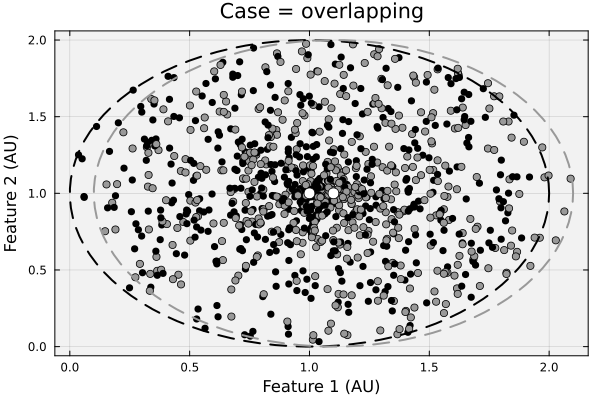

In [1296]:
let

    dataset = D̂; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    circle_one = fixedcircle(c̄₁);
    circle_two = fixedcircle(c̄₂);

    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = :black;
        if label == 2
            c = :gray60
        end
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", mec=:navy, c=c)
    end
    
    scatter!([c̄₁[1]], [c̄₁[2]], ms=6, mec=:black, c=:white, label="")
    scatter!([c̄₂[1]], [c̄₂[2]], ms=6, mec=:gray60, c=:white, label="")
    plot!(circle_one[:,1], circle_one[:,2], lw=2, c=:black, ls=:dash, label="")
    plot!(circle_two[:,1], circle_two[:,2], lw=2, c=:gray60, ls=:dash, label="") 
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end

In [1297]:
do_I_see_raw_data_cloud_figure = true; # update this value if you see the raw data figure {true | false}

## Task 2: Cluster the data
In this task, we'll cluster the dataset $\mathcal{D}$ where we exclude the `faux` label, i.e., we consider only the $(x,y)$ data in the dataset. First, we'll build a `model::MyNaiveKMeansClusteringAlgorithm` instance holding information about the problem we are looking to solve; then, we'll cluster the data using [the `cluster(...)` method](src/Cluster.jl).

Let's start by constructing the dataset $\mathcal{D}$ (no hat) from $\hat{\mathcal{D}}$ by remove the column corresponding to the `faux` label $l$. We'll save the data in the `D::Array{Float64,2}` variable:

In [1299]:
D = D̂[:,1:end-1]; # all the rows, cols = {1,2} (no label column)

Next, let's build the model instance. The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in, as well as two derived fields that we computed in [the `build(...)` method](src/Factory.jl), the centroids and initial assignments: 
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_1, \dots, \mu_K$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the clustered index that each data point is assigned to. We initialize the assignments randomly.

We've updated our implementation to take the dataset $D$ and have reworked the computation of the initial value of the centroids. It is not based on the initial random cluster assignment. _Fill in the missing code to build our clustering model_.

In [1301]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = size(D,2), # only (x,y)
        number_of_points = total_number_of_points,
        K = K,
        ϵ = ϵ,
        dataset = D, # does not include the faux label
));

#### Visualize the initial centroids and assignments
`Unhide` the code block below to see how we plotted the initial assignments and centroids. Each data point, i.e., feature vector (shown by the circles), is initially assigned to a random cluster, and the centroids dictionary is initialized based on the initial cluster assignment, where the centroids are shown as `+.`
* __Summary__: Depending upon the case, i.e., the value of $\bar{c}_{2}$, there will be two distinct (but randomly mixed up) clusters or a single (ish) cloud with mixed up values. The initial cluster centroids will be somewhere between the clouds for the `distinct` case and buried inside the cloud for the `overlapping` case. This is where [the K-means method](https://en.wikipedia.org/wiki/K-means_clustering) starts, i.e., its initial belief about how the data should be partitioned.

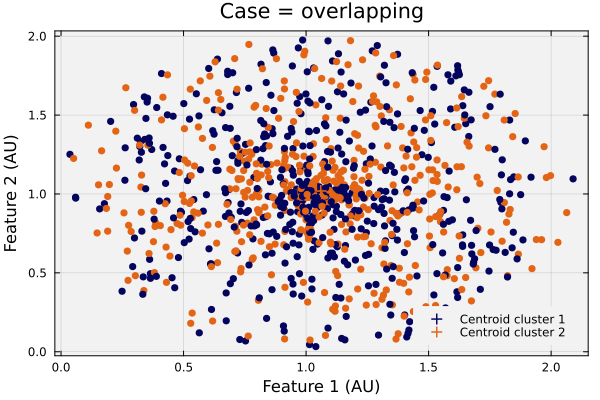

In [1303]:
let

    dataset = D; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
   
    assignments = copy(model.assignments);
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = copy(model.centroids);
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=6, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end

In [1304]:
do_I_see_initial_unclustered_data_figure = true; # update this value if you see the figure with the initial (random) clustered data {true | false}

### Execute the Clustering
Next, we'll call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments (and returns the clustering results):

* __Data__: `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the feature vectors $\mathbf{x}\in\mathbb{R}^{m}$ as columns. Its values can be any subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* __Model__: `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, i.e.,  the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, the model can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why an abstract generic type?__ Suppose we have different K-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* __Verbose (optional)__: `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* __Measure (optional)__:`d::Any`. The optional distance argument is the $d(p,q)$ function and can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 


The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `result::NamedTuple.`
* The `result` named tuple has the fields `{assignments|centroids|loopcount).` The `assignments` field is an array of integers that tells us which cluster each data point belongs to. The `centroids` field is a dictionary holding the centroids of the clusters. The `loopcount` field is an integer that tells us how many iterations the algorithm took to converge.

In [1306]:
result = cluster(D, model, verbose = false); # cluster the data with the verbose flag set to false

#### Visualize clustering results
`Unhide` the code block below to see how we plotted the cluster results. In addition, we've overlayed the data centers and the radius lines to see how the clustered data looks compared with the clustered data. 
* __Summary__: In the `distinct` case with two clusters, the [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) will produce clusters corresponding to a single `faux` label, i.e., the cluster will have either all orange or all blue elements that are contained in the radius one circle. In the `overlapping` case, there is a boundary between clusters that may have data points in particular clusters.

Note that because of the randomness of the initial assignment, sometimes cluster 2 (orange) will be on the left, and cluster 1 (blue) will be on the right, or vice-versa. Thus, the labels will be switched but still be distinct.

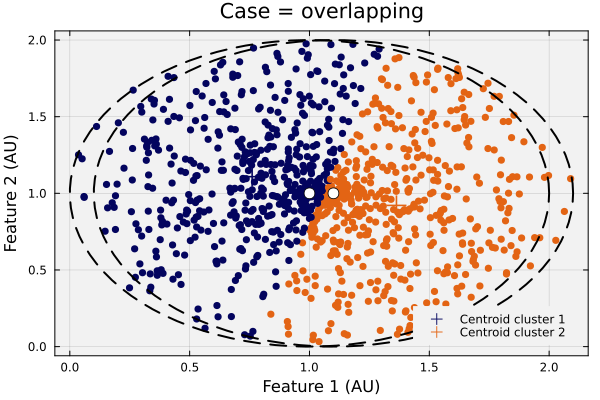

In [1308]:
let

    dataset = D;
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    assignments = result.assignments;
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result.centroids;
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=10, markerstrokewidth=2, markershape = :plus)
    end
    current();

    circle_one = fixedcircle(c̄₁);
    circle_two = fixedcircle(c̄₂);
    plot!(circle_one[:,1], circle_one[:,2], lw=2, c=:black, ls=:dash, label="")
    plot!(circle_two[:,1], circle_two[:,2], lw=2, c=:black, ls=:dash, label="") 
    scatter!([c̄₁[1]], [c̄₁[2]], ms=6, mec=:black, c=:white, label="")
    scatter!([c̄₂[1]], [c̄₂[2]], ms=6, mec=:black, c=:white, label="")

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
    title!("Case = $(case_label)", fontsize=18)
end

In [1309]:
do_I_see_clustered_data_figure = true; # update this value if you see the figure with the clustered data {true | false}

### Compute the quality of the clusters using the silhouette score
The quality (correctness) of clusters can be computed [in various ways](https://juliastats.org/Clustering.jl/stable/validate.html). Here, we'll use [the silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
* __The silhouette score__ is a measure of how similar an object is to its cluster (cohesion) 
compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a high value indicates that the object is well-matched to its cluster and poorly matched to neighboring clusters.

Assume that we have clustered the data into $K$ clusters $\mathcal{C} = \{c_1, c_2, \ldots, c_K\}$.
Then, for a data point $\mathbf{x}_i\in c_i$, let $a(i)$ denote the average distance between $\mathbf{x}_i\in{c}_{i}$ and all other points $\mathbf{x}_{j}\in{c_i}$ where $i\neq{j}$:
$$
\begin{equation}
a(i) = \frac{1}{|c_i| - 1}\sum_{j\in c_i, j\neq i}d(i,j)
\end{equation}
$$
The term $|c_i|$ denotes the number of data points in cluster $c_i$, and $d(i,j)$ denotes the distance between data points $\mathbf{x}_i\in{c_{i}}$ and $\mathbf{x}_j\in{c_{i}}$.
Thus, $a(i)$ measures the compactness of cluster $c_{i}$. Next, we define $b(i)$, to be the smallest mean distance of data point $\mathbf{x}_{i}$ to all points in any other cluster in which point $i$ is not a member. The cluster with this smallest mean dissimilarity is said to be the _neighboring cluster_ of data point $i$ because it is the next best-fit cluster for data point $i$:
$$
\begin{equation}
b(i) = \min_{j\neq i}\frac{1}{|c_j|}\sum_{j\in c_j}d(i,j)
\end{equation}
$$
Putting it all together, the silhouette score $s(i)$ for data point $\mathbf{x}_i$ is defined as:
$$
\begin{equation}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}\quad\text{if}\,|c_i|>1
\end{equation}
$$
If $|c_i|=1$, then $s(i)=0$. This gives a silhouette score for each data point as:
$$
\begin{equation}
   s(i) =
   \begin{cases}
      1 - a(i)/b(i) & \text{if } a(i) < b(i)\\ 
      0 & \text{if } a(i) = b(i)\\
      b(i)/a(i) - 1 & \text{if } a(i) > b(i)
   \end{cases}
\end{equation}
$$
This definition shows $-1\leq s(i)\leq 1$. 
The mean $s(i)$ of all data points in a cluster measures how tightly grouped the points in the cluster are. Thus, the mean of $s(i)$ over all data in the entire dataset measures how appropriately the data have been clustered.

We've implemented the computation of the silhouette score in [the `silhouette(...)` method](src/Cluster.jl). _Call the [the `silhouette(...)` method](src/Cluster.jl) to compute the silhouette score_:

In [1312]:
s, s̄ = let

    a = result.assignments;
    s = silhouette(D,a);
    s̄ = mean(s)
    s,s̄
end;

In [1340]:
println("The overall mean silhouette score for distance = $(distance) is: $(s̄)")

The overall mean silhouette score for distance = 0.10000000000000009 is: 0.28724972427471634


### Alternative quality assessment
We have another piece of data the clustering algorithm didn't have: the `faux` label. Let's use this data to compute the fraction of incorrectly clustered points. This will get us close to a problem we'll spend significant time on: the [binary classification problem](https://en.wikipedia.org/wiki/Binary_classification). Consider the binary case, i.e., $K = 2$, and only when the blue points are the leftmost cluster. If you meet this criteria, then change the `do_I_meet_the_alternative_assessment_conditions::Bool` flag to `true`:

In [1315]:
do_I_meet_the_alternative_assessment_conditions = true; # change to true if K = 2 and blue is on the left

In [1316]:
error_fraction = let

    error_fraction = nothing;
    if (do_I_meet_the_alternative_assessment_conditions == true)

        errors = 0;
        a = result.assignments;
        for i ∈ 1:total_number_of_points
            errors += (a[i] == D̂[i,3]) ? 0.0 : 1.0;
        end
        error_fraction = (errors)/total_number_of_points;    
    else
        @warn "Alternative assessment not applicable"
    end
    error_fraction
end;

In [1317]:
error_fraction

0.413